## Perceptual decision making

### 1. Data generation
$u(t)= \bigg\{ \begin{array}{ll} \bar{u} + \xi (t) & \text{if } 5 \leq t \leq 45 \\  \xi (t) & otherwise \end{array}$

$\bar{u}$ stimulus strength, drawn from a uniformormly from $\pm \frac{3.2}{100} \{1,2,4,8,16\}$ 

$\xi (t)$ is background noise, drawn from a normal distribution with mean 0 and standard deviation 0.03. 

resample for each trial. noise resampled for each time step. 

target $y$ is $sgn(\bar{u})$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy.linalg as la
# #%matplotlib inline

In [2]:
# Below snippit taken from PyTorch quickstart tutorial
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

cpu


In [3]:
class DecisionDataset(Dataset):
    def __init__(self, n_trials, n_time_step=75):   
        """
        Generate perceptual decision-making data.

        Parameters
        ----------
        n_trials : int
            Number of trials.
        n_time_step : int (Default: 75)
            Number of time steps.
        Returns
        -------
        u : array, shape (n_trials,n_time_step)
            input 
        y : array, shape (n_trials,n_time_step)
            output 
        """
        strength_choices = (3.2/ 100)  * np.array([1,2,4,8,16, -1,-2,-4,-8,-16])
        n_time_step = 75
        time_step= 20 #ms

        u = np.zeros([n_trials,n_time_step])
        y = np.zeros([n_trials,n_time_step])

        for trial in range(n_trials):
            strength = np.random.choice(strength_choices)

            for t in range(0,n_time_step):
                if t>=5 and t<=45:
                    #noise with std 0.03
                    u[trial,t] = strength + np.random.normal(0,0.03)
                else:
                    u[trial, t] = np.random.normal(0,0.03)

                y[trial, t] = np.sign(strength)
        
        self.u = torch.tensor(u, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.n_trials = n_trials
        
    def __len__(self):
        return self.n_trials
    
    def __getitem__(self, idx):
        return self.u[idx,:], self.y[idx,:]

torch.Size([32, 75]) torch.Size([32, 75])


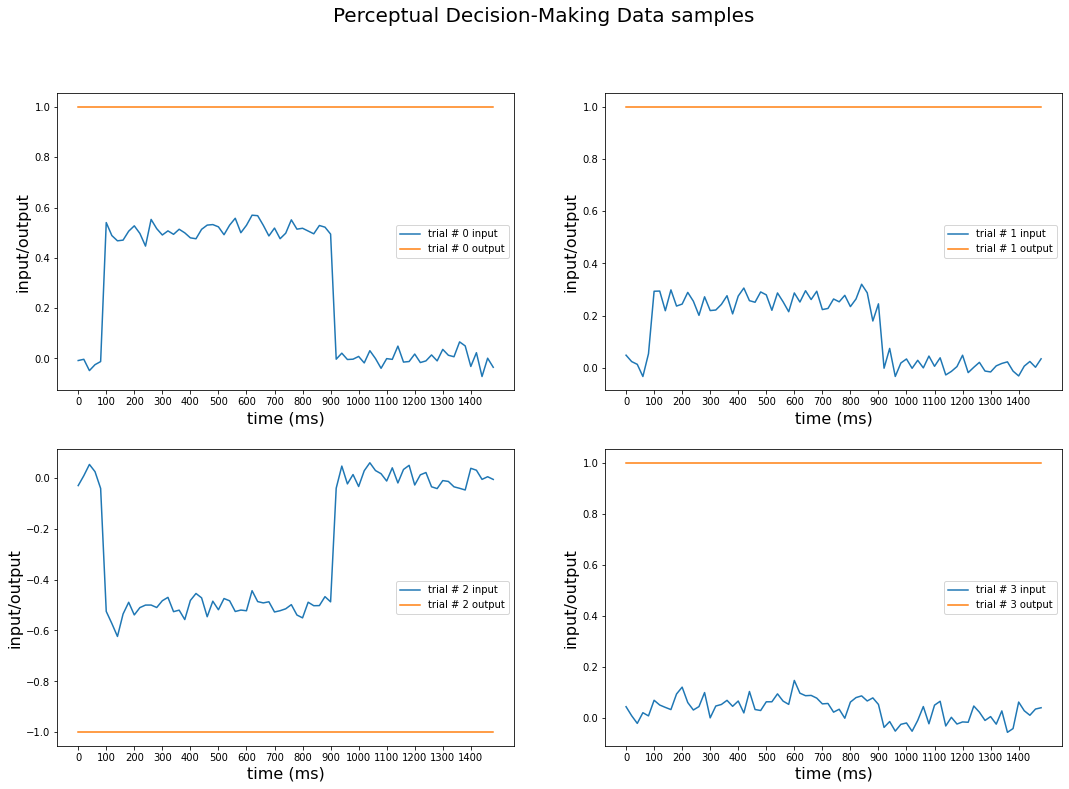

In [4]:
d_data = DecisionDataset(1000)
d_dataloader = DataLoader(d_data, batch_size=32)

u_arr, y_arr = next(iter(d_dataloader))
print(u_arr.shape, y_arr.shape)

plt.figure(figsize=(18,12))
plt.suptitle('Perceptual Decision-Making Data samples', fontsize=20)
for idx in range(4):
    plt.subplot(2,2,idx+1)
    plt.plot(u_arr[idx,:], label='trial # {} input'.format(idx))
    plt.plot(y_arr[idx,:], label='trial # {} output'.format(idx))
    plt.xlabel('time (ms)', fontsize=16)
    #dt = 20msb
    plt.xticks(np.arange(0, 75, step=5), np.arange(0, 1500, step=100))
    plt.ylabel('input/output', fontsize=16)
    plt.legend()

### 2. Recurrent neural network
one dimensional input and output, 

N units in the hidden layer, 

left and right connectivity vector $m, n$ trainable parameters, 

fixed input and output weights $I, W$. 

trainable and fixed weights are drawn from standard normal distribution. 

$\tau \frac{dx_i}{dt} = -x_i + \sum_{j=1}^N J_{ij} \phi(x_j) + I_i u(t)$ 

$\phi(x) = \tanh$ 

$\tau = 100 ms$ 
 
$\Delta t = 20 ms$ 

$J = \frac{1}{N} mn^T$ 

Using forward Euler method to solve the differential equation. 

$x_i(t+ \Delta t) = x_i(t) + \frac{1}{\tau}  \Delta t  \bigg( -x_i(t) + \sum_{j=1}^N J_{ij} \phi(x_j(t)) + I_i u(t) \bigg)$ 



In [245]:
import torch
import torch.nn

class RNN(nn.Module):
    
    def __init__(self, network_size=128,rank=1):
        
        super(RNN, self).__init__()
        self.network_size = network_size
        self.rank=rank
        
        # Weight initialization
        #unit rank rnn weight matrix J=mn^T/n
        if rank==1:
            self.m = nn.Parameter(torch.Tensor(self.network_size))
            self.n = nn.Parameter(torch.Tensor(self.network_size))
            self.wi = torch.Tensor(self.network_size)
            self.w = torch.Tensor(self.network_size)
            self.x0= torch.Tensor(self.network_size)
        else:
            self.m = nn.Parameter(torch.Tensor(self.network_size,self.rank))
            self.n = nn.Parameter(torch.Tensor(self.network_size,self.rank))
            self.wi = torch.Tensor(self.network_size, self.rank)
            self.w = torch.Tensor(self.network_size,1)
            self.x0= torch.Tensor(self.network_size,1)
        
                # Parameters for weight update formula
        self.tau = 100 #ms
        self.dt = 20 #ms

        # Activation function
        self.activation = nn.Tanh()
        
        with torch.no_grad():
            self.m.normal_(std=1)
            self.n.normal_(std=1)           
            self.w.normal_(std=4)
            self.x0.zero_()
            self.wi.normal_(std=1)

        #orthogonalize m and wi
            m=self.m.detach().numpy()
            wi=self.wi.detach().numpy()
            wi= wi - np.dot(m, wi) * m / np.dot(m, m)
            wi= wi / la.norm(wi)
            self.wi=torch.tensor(wi, dtype=torch.float32)

    def forward(self, u,visible_activity=False):
        input_len=u.size(1)
        batch_size=u.size(0)
        x = self.x0 
        z = torch.zeros(u.shape)
        
        if visible_activity:
            unit_activity = torch.zeros(batch_size, input_len+1, self.network_size)
            unit_activity[:,0,:] = x
        
        #unit rank rnn weight matrix J=mn^T/n
        J = torch.matmul(self.m[:,None], self.n[None,:]) / self.network_size
        
        for i in range(input_len):
            delta_x = (
                -x 
                + torch.matmul(self.activation(x), J) 
                + torch.matmul(u[:,i,None], self.wi[None,:])
            ) * (self.dt / self.tau)
            
            x = x + delta_x
            if visible_activity:
                unit_activity[:,i,:] = x
            
            output = torch.matmul(self.activation(x), self.w) / self.network_size            
            z[:, i] = output    
        if visible_activity:
            return z, unit_activity
        else:
            return z

In [246]:
model = RNN(128)
n=model.n
m=model.m
wi=model.wi
w=model.w
x0=model.x0

# print("shape of m:",m.shape)
# print("shape of n:",n.shape)
# print("shape of wi:",wi.shape)
# print("shape of w:",w.shape)
orthogonal_mn=torch.dot(m,n)
print("inner product of m and n:",orthogonal_mn)

orthogonal_mi=torch.dot(m,wi)
print("inner product of m and wi:",orthogonal_mi)

J=torch.matmul(m, n.T) / model.network_size
J=J.detach().numpy()
print('rank of J:',la.matrix_rank(J))

inner product of m and n: tensor(0.0133, grad_fn=<DotBackward0>)
inner product of m and wi: tensor(2.9802e-08, grad_fn=<DotBackward0>)
rank of J: 1


### 3. Training
train a network of size $N=128$. batch size 32 trals. and specific lost function is defined as the mean squared error of last $T=15$ time step of each trial:

$loss = \frac{1}{32 * 15} \sum_{i=1}^{32} \sum_{t=45}^{60} (z_i(t) - y_i(t))^2$ 

learning rate $0.05$ , Adam optimizer.

In [222]:
# Training function slightly modified from PyTorch quickstart tutorial
def train(dataloader, model, loss_fn, optimizer, T=15):
    size = len(dataloader.dataset)
    optimizer.zero_grad()
    model.train(True)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        # print("pred shape: ", pred.shape)
        loss = loss_fn(pred[:,-T:], y[:,-T:])

        # print(pred[0, :])
        # print(pred[0, -T:])
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        
        loss, current = loss.item(), (batch + 1) * len(X)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [247]:
d_dataset = DecisionDataset(2000)
train_dataloader = DataLoader(d_dataset, batch_size=1)
# model = RNN(128)
learning_rate = 5e-3
T=15
# model = RNN(128)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train(train_dataloader, model, loss_fn, optimizer, T=T)

loss: 0.999460  [    1/ 2000]
loss: 0.999588  [    2/ 2000]
loss: 1.000026  [    3/ 2000]
loss: 0.999885  [    4/ 2000]
loss: 0.999686  [    5/ 2000]
loss: 1.000320  [    6/ 2000]
loss: 1.000105  [    7/ 2000]
loss: 1.000100  [    8/ 2000]
loss: 0.999746  [    9/ 2000]
loss: 0.999984  [   10/ 2000]
loss: 1.000059  [   11/ 2000]
loss: 0.999919  [   12/ 2000]
loss: 1.000097  [   13/ 2000]
loss: 0.999753  [   14/ 2000]
loss: 0.999980  [   15/ 2000]
loss: 1.000196  [   16/ 2000]
loss: 0.999853  [   17/ 2000]
loss: 0.999784  [   18/ 2000]
loss: 0.999787  [   19/ 2000]
loss: 0.999980  [   20/ 2000]
loss: 0.999863  [   21/ 2000]
loss: 0.999179  [   22/ 2000]
loss: 1.000195  [   23/ 2000]
loss: 0.999484  [   24/ 2000]
loss: 0.999838  [   25/ 2000]
loss: 0.999204  [   26/ 2000]
loss: 1.000284  [   27/ 2000]
loss: 1.000148  [   28/ 2000]
loss: 0.999606  [   29/ 2000]
loss: 0.999345  [   30/ 2000]
loss: 0.999695  [   31/ 2000]
loss: 0.999568  [   32/ 2000]
loss: 1.000138  [   33/ 2000]
loss: 0.99

In [248]:
n=model.n
m=model.m
wi=model.wi
w=model.w
print("inner product of m and n:",torch.dot(m,n))
print("inner product of m and I:",torch.dot(m,wi))
#rank of J=1/nmn.T
J=torch.matmul(m, n) / model.network_size
J=J.detach().numpy()
print('rank of J:',la.matrix_rank(J,tol=1e-3))

inner product of m and n: tensor(211.7894, grad_fn=<DotBackward0>)
inner product of m and I: tensor(-7.0836, grad_fn=<DotBackward0>)
rank of J: 1


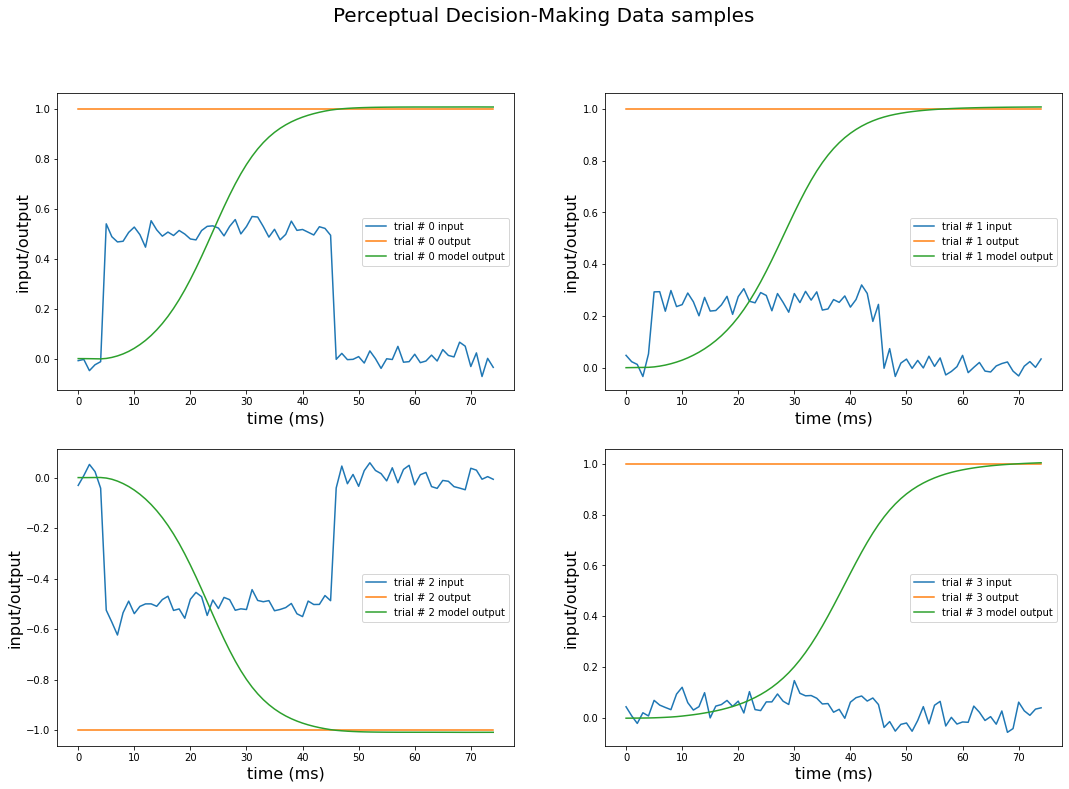

In [250]:

u_arr, y_arr = next(iter(d_dataloader))

plt.figure(figsize=(18,12))
plt.suptitle('Perceptual Decision-Making Data samples', fontsize=20)
for idx in range(4):
    plt.subplot(2,2,idx+1)
    plt.plot(u_arr[idx,:], label='trial # {} input'.format(idx))
    plt.plot(y_arr[idx,:], label='trial # {} output'.format(idx))
    plt.plot(model(u_arr[idx,:].unsqueeze(0)).detach().numpy().squeeze(), label='trial # {} model output'.format(idx))
    plt.xlabel('time (ms)', fontsize=16)
    #dt = 20msb
    # plt.xticks(np.arange(0, 75, step=5), np.arange(0, 1500, step=100))
    plt.ylabel('input/output', fontsize=16)
    plt.legend()

[[0.01095023 0.05572194 0.02079232]
 [0.         1.66760221 2.44016071]
 [0.         0.         1.35914058]]


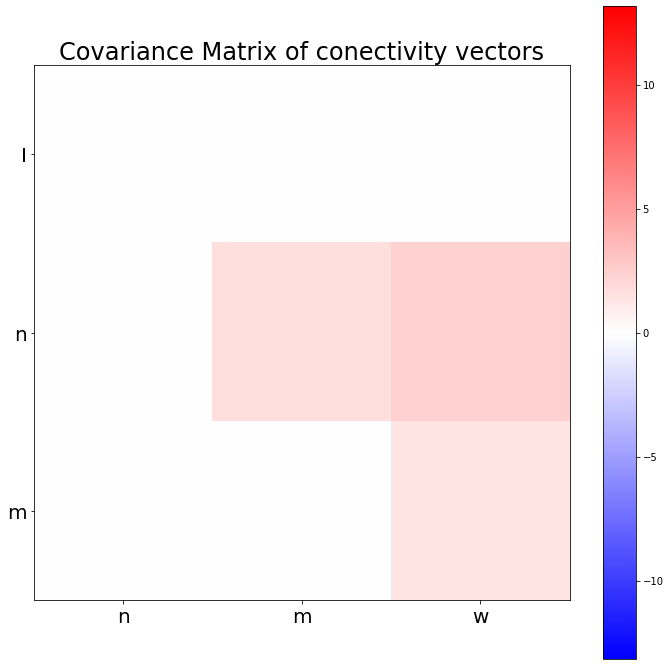

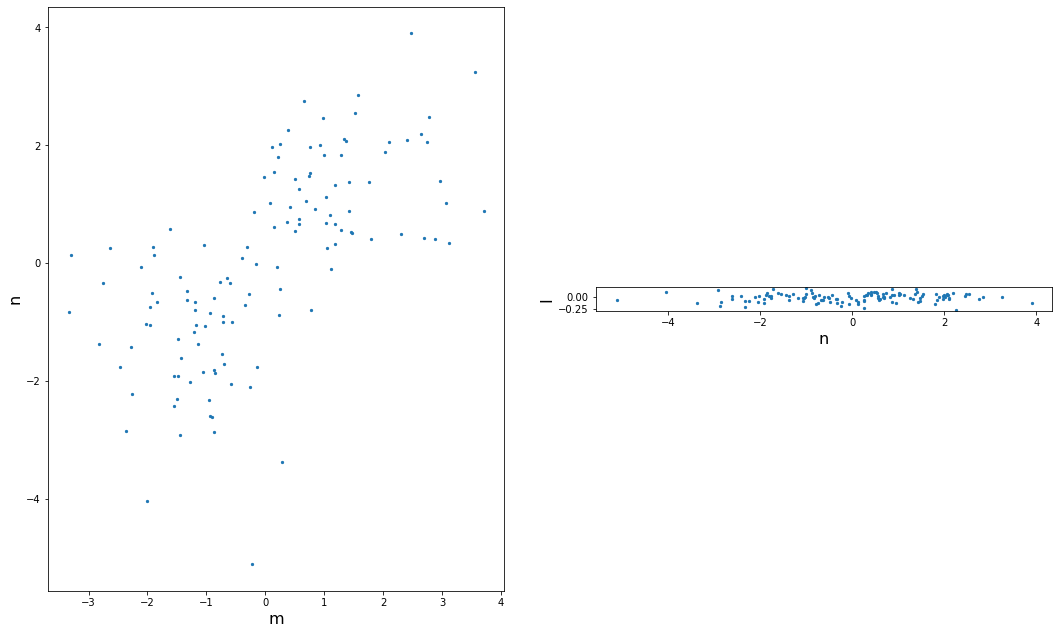

In [267]:
m=model.m.detach().numpy()
n=model.n.detach().numpy()
wi=model.wi.detach().numpy()
w=model.w.detach().numpy()
network_size=model.network_size
m=-m
n=-n
vectors = [wi, n, m, w]

cov_matrix=np.cov(vectors)
bound = np.max((np.abs(np.min(cov_matrix)), np.abs(np.max(cov_matrix))))

cov_matrix=np.triu(cov_matrix,1)
cov_matrix=cov_matrix[0:3,1:4]
print(cov_matrix)

plt.figure(figsize=(12,12))
plt.title('Covariance Matrix of conectivity vectors', fontsize=24)
plt.imshow(cov_matrix,cmap= "bwr", vmin=-bound, vmax=bound)
plt.xticks(np.arange(0, 3, step=1), ['n', 'm', 'w'], fontsize=20)
plt.yticks(np.arange(0, 3, step=1), ['I','n', 'm'], fontsize=20)
plt.colorbar()

plt.figure(figsize=(18,12))

plt.subplot(1,2,1)
plt.scatter(m, n, s=5)
plt.xlabel('m', fontsize=16)
plt.ylabel('n', fontsize=16)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.draw()
plt.subplot(1,2,2)
plt.scatter(n, wi, s=5)
plt.xlabel('n', fontsize=16)
plt.ylabel('I', fontsize=16)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.draw()
